In [3]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pathlib import Path

import xtrack as xt
import xcoll as xc

In [4]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self['data'].fields:
            for i, bpm in enumerate(self['data'][crate]['ChannelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self['data'][crate]['Positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [5]:
bpm_path = Path('/Users/lisepauwels/sps_simulations/MD_data/20251010/bpms/')

In [13]:
file_names = {'REF_MICADO_CORR_NEG': ["2025-10-10T12_10_49.parquet", "2025-10-10T12_11_07.parquet", "2025-10-10T12_11_25.parquet"],
              'REF_MICADO_CORR_POS': ["2025-10-10T12_13_13.parquet", "2025-10-10T12_13_31.parquet", "2025-10-10T12_13_49.parquet"],
              'REF_NO_CORR_NEG' : ["2025-10-10T11_25_42.parquet", "2025-10-10T11_26_00.parquet", "2025-10-10T11_27_30.parquet"],
              'REF_NO_CORR_POS' : ["2025-10-10T11_58_49.parquet", "2025-10-10T11_59_07.parquet", "2025-10-10T11_59_25.parquet"],
              'REF_ZERO_CORR_NEG': ["2025-10-10T11_34_42.parquet", "2025-10-10T11_35_00.parquet", "2025-10-10T11_35_18.parquet"],
              'REF_ZERO_CORR_POS': ["2025-10-10T11_53_07.parquet", "2025-10-10T11_53_25.parquet", "2025-10-10T11_53_43.parquet"],
              'REF_SVD_CORR_1.2_0.8_NEG' : ["2025-10-10T12_50_17.parquet", "2025-10-10T12_50_28.parquet", "2025-10-10T12_50_46.parquet"],
              'REF_SVD_CORR_1.2_0.8_POS' : ["2025-10-10T12_48_04.parquet", "2025-10-10T12_48_22.parquet", "2025-10-10T12_48_40.parquet"],
              'REF_SVD_CORR_1.2_1.6_NEG' : ["2025-10-10T13_35_28.parquet", "2025-10-10T13_35_46.parquet", "2025-10-10T13_36_04.parquet"],
              'REF_SVD_CORR_1.2_1.6_POS' : ["2025-10-10T13_33_58.parquet", "2025-10-10T13_34_16.parquet", "2025-10-10T13_34_34.parquet"],
              'REF_SVD_CORR_2.1_0.8_NEG' : ["2025-10-10T12_54_04.parquet", "2025-10-10T12_54_22.parquet", "2025-10-10T12_54_40.parquet"],
              'REF_SVD_CORR_2.1_0.8_POS' : ["2025-10-10T12_56_46.parquet", "2025-10-10T12_57_04.parquet", "2025-10-10T12_57_22.parquet"],
              'REF_SVD_CORR_2.2_1.5_NEG' : ["2025-10-10T13_39_21.parquet", "2025-10-10T13_39_39.parquet", "2025-10-10T13_39_57.parquet"],
              'REF_SVD_CORR_2.2_1.5_POS' : ["2025-10-10T13_17_10.parquet", "2025-10-10T13_17_28.parquet", "2025-10-10T13_17_46.parquet"]}

In [ ]:
bpms_data = {}
for key in file_names:
    print(key)
    bpms_data[key] = []
    for filename in file_names[key]:
        print(filename)
        if filename in  ['2025-10-10T12_50_17.parquet'] or key in ['REF_SVD_CORR_2.2_1.5_NEG']: #For some reason these files give errors when loading.
            continue
        bpms_data[key].append(ak.Array(ak.from_parquet(Path(bpm_path, filename)),with_name='BPMCollection'))

    print(' ')

REF_MICADO_CORR_NEG
2025-10-10T12_10_49.parquet
2025-10-10T12_11_07.parquet
2025-10-10T12_11_25.parquet
 
REF_MICADO_CORR_POS
2025-10-10T12_13_13.parquet
2025-10-10T12_13_31.parquet
2025-10-10T12_13_49.parquet
 
REF_NO_CORR_NEG
2025-10-10T11_25_42.parquet
2025-10-10T11_26_00.parquet
2025-10-10T11_27_30.parquet
 
REF_NO_CORR_POS
2025-10-10T11_58_49.parquet
2025-10-10T11_59_07.parquet
2025-10-10T11_59_25.parquet
 
REF_ZERO_CORR_NEG
2025-10-10T11_34_42.parquet
2025-10-10T11_35_00.parquet
2025-10-10T11_35_18.parquet
 
REF_ZERO_CORR_POS
2025-10-10T11_53_07.parquet
2025-10-10T11_53_25.parquet
2025-10-10T11_53_43.parquet
 
REF_SVD_CORR_1.2_0.8_NEG
2025-10-10T12_50_17.parquet
2025-10-10T12_50_28.parquet
2025-10-10T12_50_46.parquet
 
REF_SVD_CORR_1.2_0.8_POS
2025-10-10T12_48_04.parquet
2025-10-10T12_48_22.parquet
2025-10-10T12_48_40.parquet
 
REF_SVD_CORR_1.2_1.6_NEG
2025-10-10T13_35_28.parquet
2025-10-10T13_35_46.parquet
2025-10-10T13_36_04.parquet
 
REF_SVD_CORR_1.2_1.6_POS
2025-10-10T13_33_5

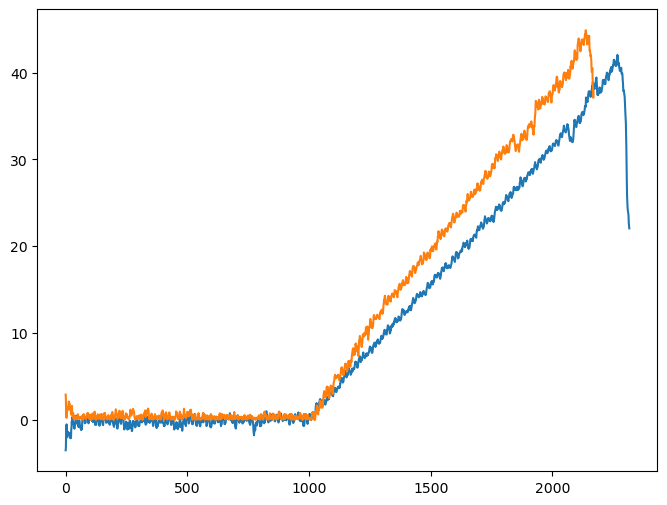

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(bpms_data['REF_MICADO_CORR_POS'][0].hor_turn_position[0] - np.nanmean(bpms_data['REF_MICADO_CORR_POS'][0].hor_turn_position[0][500:1015]))
ax.plot(abs(bpms_data['REF_MICADO_CORR_NEG'][0].hor_turn_position[0] - np.nanmean(bpms_data['REF_MICADO_CORR_NEG'][0].hor_turn_position[0][500:1015])))

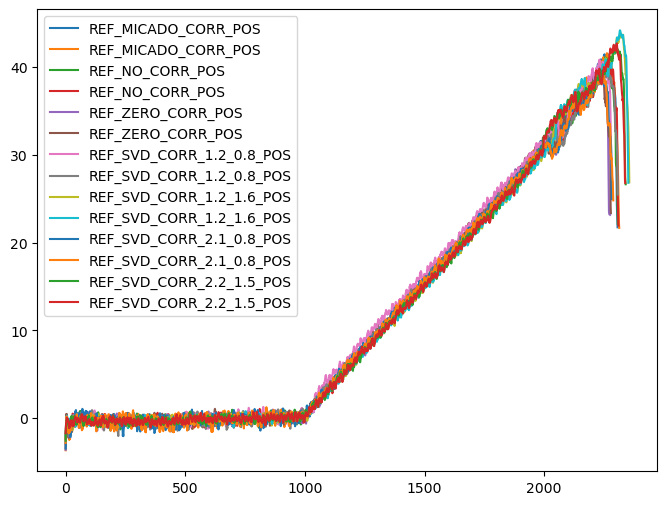

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for key in bpms_data:
    if 'POS' in key:
        for i in range(1, len(bpms_data[key])):
            if i == 0:
                ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015]), label=f'{key}')
            else:
                ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015]))
ax.legend()